[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/image-retrieval/bag-of-visual-words/bag-of-visual-words.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/image-retrieval/bag-of-visual-words/bag-of-visual-words.ipynb)

## What is Bag of Visual Words?

In computer vision, **bag of visual words (BoVW)** is one of the pre-machine learning models used for *object recognition*. This includes finding images in a database that are similar to a given query image, image similarities, and compact representation of images. 

The model derives from **bag of words** in natural language processing (NLP). Which is where a chunk of text is split into words or sub-words and those components are collated into an unordered list, the so called "bag of words" (BoW). 

<center><div> <img src="https://raw.githubusercontent.com/pinecone-io/examples/master/learn/image-retrieval/bag-of-visual-words/assets/nlp-bow-bag.png" alt="Drawing" style="width:300px;"/></div> </center> 

Similarly, in bag of *visual* words the images are represented by patches, and their unique patterns (or *visual features*) are extracted into an imaginary bag. However, these visual features are not "visual words" just yet.

<center><div> <img src="https://raw.githubusercontent.com/pinecone-io/examples/master/learn/image-retrieval/bag-of-visual-words/assets/BOW.png" alt="Drawing" style="width:400px;"/></div> </center>

Visual features consist of two items:

* **Keypoints** are points in an image, they do *not* change if the image is rotated, expanded, or scaled.
* **Descriptors** are a description of the features found at that keypoint.

These visual features can be detected and extracted using a feature detector, such as *SIFT (Scale Invariant Feature Transform)*, *ORB (Oriented FAST and Rotated BRIEF)*, or *SURF (Speeded Up Robust Features)*.

The most common is *SIFT*; being invariant to scale, rotation, translation, illumination, and blur. SIFT converts each image patch into a $128$-dimensional vector, i.e., the *descriptor* of the visual feature.

Each image will be represented by many of these SIFT vectors, which the order is not considered, only their presence within an image.

Once we have identified the visual features, we need to build a *codebook*, also called dictionary or vocabulary. This codebook acts as a repository of all existing *visual words* (similar to an *actual* dictionary book, like the English dictionary).

The codebook also acts as a mapping from visual features to visual words.

How? The idea is to group similar visual features to form a visual word, which will be represented by a vector. The standard approach for grouping visual features into visual words is *k-mean clustering*.

K-means divides the data into $k$ clusters, where $k$ is chosen by us. Once the data is grouped, k-means calculates the mean for each cluster, i.e., a central point between all of the vectors in a group. The central point represents a *centroid*, i.e., a *visual word*. 

<center><div> <img src="https://raw.githubusercontent.com/pinecone-io/examples/master/learn/image-retrieval/bag-of-visual-words/assets/clustering.png" alt="Drawing" style="width:400px;"/></div> </center>

After finding the centroids, k-means iterates through each data point (visual feature) and checks which centroid (visual word) is nearest. If the nearest centroid has changed, the data point switches grouping, being assigned to the new nearest centroid. Then, we repeat the centroid computation of above.

This step is performed over a given number of iterations, or until the centroid positions have stabilized.

With that in mind, how do we choose the number of centroids, $k$?

It is more of an art than a science, but there are a few things to consider. Primarily, how many visual words can cover the various *relevant* visual features in the dataset.

That's not an easy thing to figure out, and it's always going to require some guesswork. However, we can think of it using the language equivalent, *bag of words*.

If our language dataset covered several documents about a specific topic in a single language, we would find less unique words than if we have thousands of documents, spanning several language, about a whole range of topics.

The same is true for images, dogs and/or animals could be a topic, buildings would be another topic. As for the equivalent of different languages, this is not a perfect metaphor but we could think of different photography styles, drawings or catroons. All of these added layers of complexity increase the number of visual words needed to accurately represent the dataset.

For us here, we could start with chosing a smaller $k$ value, e.g., $100$ or $150$, and re-run the code multiple times changing $k$ until convergence and/or our model seems to be identifying images well.

If we chose $k=150$, k-means will generate $150$ centroids, and therefore $150$ visual words.

When we perform the mapping from new visual feature vectors to the nearest centroid (i.e., visual word), we are essentially categorizing visual features into a more limited set of visual words. This process of reducing the number of possible unique values/vectors is called *quantization*. So for us, this is *vector quantization*.

<center><div> <img src="https://raw.githubusercontent.com/pinecone-io/examples/master/learn/image-retrieval/bag-of-visual-words/assets/vq.png" alt="Drawing" style="width:300px;"/></div> </center>

Using a limited set of visual words allows us to compress our image descriptions into a set of visual word IDs. And, more importantly, represent similar features shared across images using a shared set of visual words.

That means that the *visual words* shared by two images of churches may be quite large, i.e., they're similar. Whereas an image of a church and an image of a dog will share far fewer visual words, i.e., they're dissimilar.

After those steps, all image patches are represented by visual words. We can visualize them using histograms.

The *x-axis* of the histogram is the codebook, while the *y-axis* is the frequency of each visual word in the image.

If we consider $2$ images, we can represent the image histograms as follows:

<center><div> <img src="https://raw.githubusercontent.com/pinecone-io/examples/master/learn/image-retrieval/bag-of-visual-words/assets/histograms-basic.png" alt="Drawing" style="width:400px;"/></div> </center> 

To create these representations, we have converted each image into a sparse vector where each value in the vector represents an item in the codebook (i.e., the x-axis in the histograms). Most of the values in each vector will be *zero* because most images will only contain a small percentage of total number of visual words, this is why we refer to them as *sparse* vectors.

As for the non-zero values in our sparse vector, they are calculated in the same way that we calculated our histogram bar heights. They are equal to the frequency of a particular visual word in an image.

This works, but it's a crude way to create these sparse vector representations. Because many visual words are actually not that important. If we think about text documents, we tend to have some words that are more relevant than others. For example, a document about *"Roman History"* will contain the words *"the"* and *"Rome"*. The word *"the"* is not specific to that article, and it's a very common word, so we would view this as being less relevant than the word *"Rome"*.

This problem is also found in images. A visual word extracted from a patch of sky in an image is unlikely to tell us whether this image is of a church or a dog. Images are the same, some visual words in an image are more relevant than others.

<center><div> <img src="https://raw.githubusercontent.com/pinecone-io/examples/master/learn/image-retrieval/bag-of-visual-words/assets/tf-idf.png" alt="Drawing" style="width:300px;"/></div> </center>

In the example above, we would expect a visual word representing the sky $(1)$ to be less relevant than a visual word representing the cross on top of the bell tower $(2)$.

That is why it is important to adjust the values of our sparse vector to give more weight to more relevant visual words, and less weight to less relevant visual words. 

To do that, we can use the *tf-idf* (*term-frequency inverse document frequency*) formula, which is calculated as follows:

$$tf\textrm{--}idf_{t,d} = tf_{t,d} * idf_t = tf_{t,d} * log\frac{N}{df_t}$$

where:

* $tf_{t,d}$ is the term frequency of the visual word $t$ in the image $d$ (the number of times $t$ occurs in $d$).
* $N$ is the total number of images.
* $df_t$ number of images containing visual word $t$.
* $log\frac{N}{df_t}$ measures the how common visual word $t$ is across all images in the database. This is low if the visual word $d$ occurs many times in the image, high otherwise.

After *tf-idf*, we can visualize the vectors via our histogram again, which will better reflect the image's features.

<center><div> <img src="https://raw.githubusercontent.com/pinecone-io/examples/master/learn/image-retrieval/bag-of-visual-words/assets/histograms.png" alt="Drawing" style="width:400px;"/></div> </center>

Before we were giving the same importance to image's patches in an image, now they're adjusted based on relevance and normalized.

We've now trained our codebook, and learned how to process each vector for better relevance and normalization; we are now ready to test everything using different images. 

The testing process is similar to the training process: if we are using a new dataset, we just drop the part where we build a codebook, because we already have it. All we do is:

1. extract the visual features.
2. transform them into visual words using the codebook generated during training.
3. populate the sparse vector of each image based on it's visual words.
4. tf-idf*ify* the vectors.

If we are using the same dataset, we don't need to go throgh the above steps again as the images have been already trasformed into visual words!

After that, we're ready to compare the sparse vector representations of our images in order to find similar or dissimilar images.

There might be different methodologies to compare them, based on calculating the similarity or distance between two vectors:

1. *Cosine similarity*.
2. *Euclidian distance*.
3. *Dot product similarity*.

The standard choice is the *cosine similarity* which measures the angle between vectors, vectors pointing in a similar direction have a lower angular separation and therefore a higher cosine similarity.

Euclidian distance calculates the vector distance rather than angle. Dot product looks at both direction and magnitude, which can make it unsuitable without normalization.

Cosine similarity is calculated as,

$$cossim(A,B)= cos(\theta)=\frac{A \cdot B}{||A|| \space ||B||}$$

Cosine similarity generally gives a value ranging $[-1,1]$. However, if we think about the *frequency* of visual words, we cannot consider them as negative. Therefore, in IR, the angle between two term frequency vectors cannot be greater than $90°$, and cosine similarity ranges $[0,1]$.

It equals $1$ if the vectors are pointing in the same direction (the angle equals $0$), and $0$ if vectors are orthogonal.

<center><div> <img src="https://raw.githubusercontent.com/pinecone-io/examples/master/learn/image-retrieval/bag-of-visual-words/assets/cosine.png" alt="Drawing" style="width:400px;"/></div> </center>

If we consider three different images and we build a matrix based on cosine similarity,

<center><div> <img src="https://raw.githubusercontent.com/pinecone-io/examples/master/learn/image-retrieval/bag-of-visual-words/assets/cosine-img.png" alt="Drawing" style="width:400px;"/></div> </center>

we can see that cosine similarity is $1$ when the image is exactly the same, i.e., in the main diagonal. The cosine similarity approaches $0$ as the images have less in common.

Let's now see how to implement bag of visual words using Python.

## Implementing Bag of Visual Words

### Training Dataset Load and Cleaning

In [1]:
#!pip install datasets opencv-contrib-python opencv-python

First, we want to import a dataset of images to train the model. 

Feel free to use any images you like, but, if you’d like to follow along with the same images, you can download them using HuggingFace Datasets.

In [2]:
from datasets import load_dataset

# download the dataset
imagenet = load_dataset(
    'frgfm/imagenette',
    'full_size',
    split='train',
    ignore_verifications=False  # set to True if seeing splits Error
)
imagenet

Reusing dataset imagenette (/Users/jamesbriggs/.cache/huggingface/datasets/frgfm___imagenette/full_size/1.0.0/38929285b8abcae5c1305418e9d8fea5dd6b189bbbd22caba5f5537c7fa0f01f)


Dataset({
    features: ['image', 'label'],
    num_rows: 9469
})

The chosen dataset is composed of $9469$ images, representing dogs, radios, fishes, cities, and so on. We can visualise some of them below.

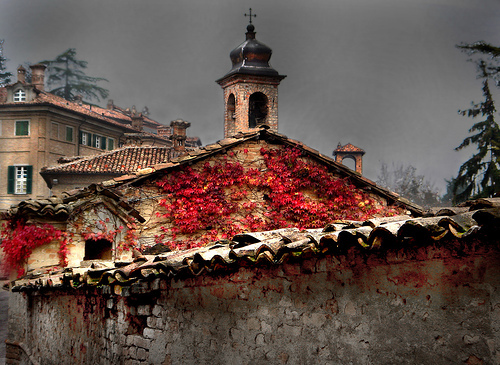

In [3]:
# important to use imagenet[0]['image'] rather than imagenet['image'][0]
# as the latter loads the entire image ctrtvgvrtttttolumn then extracts index 0 (it's slow)
imagenet[3264]['image']

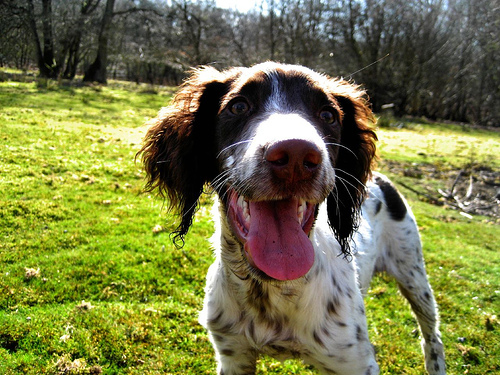

In [4]:
imagenet[5874]['image']

We can now transform these images from PIL objects to numpy arrays.

In [5]:
import numpy as np

# generate an array from the original dataset
images_training = []

for n in range(0,len(imagenet)):
    images_training.append(np.array(imagenet[n]['image']))

To simplify the model and speed-up the process, we can transform the images from *RGB* to grayscale. This will reduce the image dimension from $3$ to $2$. 

To do that, we can use ``cv2``. Note that the dataset might include a mix of RGB and grayscale images. In that case, we would need to trasform only those in RGB, while keeping the grayscale ones as they are. The below code addresses this by looking at the shape's length: if the shape equals $2$, then the image is in grayscale, if the shape is $3$, then the image is RGB.

In [6]:
import cv2

# convert images to grayscale
bw_images = []
for img in images_training:
    # if RGB, transform into grayscale
    if len(img.shape) == 3:
        bw_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    else:
        # if grayscale, do not transform
        bw_images.append(img)

Let's take a look at a transformed image.

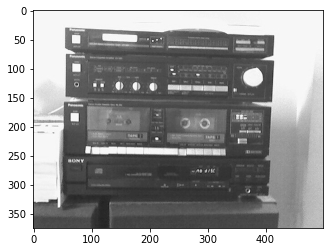

In [7]:
import matplotlib.pyplot as plt

plt.imshow(bw_images[1], cmap='gray')
plt.show()

We have now a dataset of images that we can use to train our model. Let's see how to build it.

### Visual features Extraction

The first step is to extract the image visual features (keypoints and descriptors). As previously mentioned, we will use SIFT, a feature detector.

In [8]:
# defining feature extractor that we want to use (SIFT)
extractor = cv2.xfeatures2d.SIFT_create()

# initialize lists where we will store *all* keypoints and descriptors
keypoints = []
descriptors = []

for img in bw_images:
    # extract keypoints and descriptors for each image
    img_keypoints, img_descriptors = extractor.detectAndCompute(img, None)
    keypoints.append(img_keypoints)
    descriptors.append(img_descriptors)

[ WARN:0@3.007] global /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv_contrib/modules/xfeatures2d/misc/python/shadow_sift.hpp (15) SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


Some images might return `None` when attempting to extract keypoints using SIFT. This is (usually) because the SIFT algorithm cannot detect any keypoints (common when an image is very flat without obvious edges). In that case, we remove those images from our data.

In [9]:
print(f"len before: {len(descriptors)}")
# initialize list to store idx values of records to drop
to_drop = []
for i, img_descriptors in enumerate(descriptors):
    # if there are no descriptors, add record idx to drop list
    if img_descriptors is None:
        to_drop.append(i)

print(f"indexes: {to_drop}")
# delete from list in reverse order
for i in sorted(to_drop, reverse=True):
    del descriptors[i], keypoints[i]

print(f"len after: {len(descriptors)}")

len before: 9469
indexes: []
len after: 9469


For this sample, we fortunately don't have this issue - as we can see the before/after length has not changed.

Now that we have extracted the features, we can visualize them on some images.

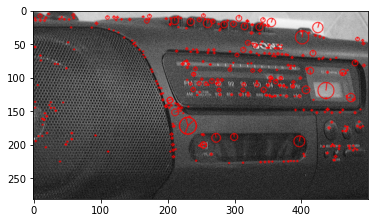

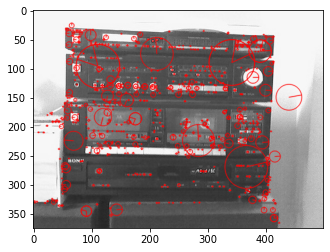

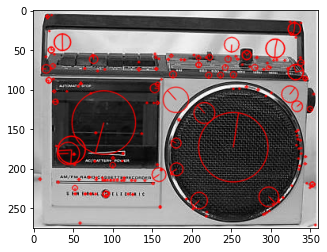

In [10]:
output_image = []
for x in range(3):
    output_image.append(cv2.drawKeypoints(bw_images[x], keypoints[x], 0, (255, 0, 0),
                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
    plt.imshow(output_image[x], cmap='gray')
    plt.show()  

The centre of each circle is the keypoint location, the line from the centre to the circle is the orientation of the keypoint, and the size of the circle is the scale at which this feature was detected.

We are now ready to build the codebook!

### Building the Codebook

To build the codebook, we will randomly sample $1000$ of the image descriptors. To create the sample we use Numpy to generate $1000$ random integer numbers from $0$ to $9469$ (the length of the dataset). We set `np.random.seed(0)` to generate the same sample for reproducability.

In [11]:
import numpy as np

# select the same numbers in each run
np.random.seed(0)
# select 1000 random image index values
sample_idx = np.random.randint(0, len(imagenet)+1, 1000).tolist()
len(sample_idx)

1000

First, we want to stack the generated descriptors into a numpy array. This will be a single array of *all* the chosen descriptors across *all* the corresponding images. To be more precise, we are going to extract the corresponding keypoints, even though we are not going to use them going ahead. 

In [12]:
# extract the sample from descriptors
# (we don't need keypoints)
descriptors_sample = []

for n in sample_idx:
    descriptors_sample.append(np.array(descriptors[n]))

In [13]:
all_descriptors = []
# extract image descriptor lists
for img_descriptors in descriptors_sample:
    # extract specific descriptors within the image
    for descriptor in img_descriptors:
        all_descriptors.append(descriptor)
# convert to single numpy array
all_descriptors = np.stack(all_descriptors)

In [14]:
# check the shape 
all_descriptors.shape

(1130932, 128)

We now have *all* descriptors (each descriptor being a 128-dimensional vector) across *all* sampled images. There are around *1,130,000* of these in total.

In [15]:
# we can count the number of descriptors contained in descriptors to confirm
count = []
for img_descriptors in descriptors_sample:
    count.append(len(img_descriptors))
# here we can see the number of descriptors for the first five images
print(f"first five: {count[:5]}")
# and if we sum them all, we should see the 39893 from before
print(f"count all: {sum(count)}")

first five: [544, 1507, 282, 688, 718]
count all: 1130932


We now want to group similar visual features (descriptors) using *k-means*. After a few tests, we chose $k=200$ for our model.

After k-means, all images will be reduced to *visual words* and we will use that to build our codebook. 

*It can be difficult to find the optimal size of our codebook - if too small, visual words could be not representative of all image regions, if too large, there could be too many visual words with little-no of them being shared between images (making comparisons very hard or impossible).*

Once built, the codebook won't change anymore, i.e., will stay fixed!

In [16]:
# perform k-means clustering to build the codebook
from scipy.cluster.vq import kmeans

k = 200
iters = 1
codebook, variance = kmeans(all_descriptors, k, iters)

### Saving Codebook

We save the codebook and key parameters like `k` into a file so that in the future we just load these when processing new images.

In [17]:
import joblib

# save number of clusters and codebook
# Joblib dumps Python object into one file
joblib.dump((k, codebook), "bovw-codebook.pkl", compress=3) 

['bovw-codebook.pkl']

To *emulate* this approach, we can go ahead and load `k` and our `codebook` from file to use for the rest of the notebook - this is optional and not necessary, feel free to not run the next code cell.

In [18]:
# load the visual features, number of clusters, and codebook 
k, codebook = joblib.load("bovw-codebook.pkl")

### Building Sparse Vectors

After building our `codebook` we can begin building the sparse vector representations of our images, this requires three steps, (1) vector quantization, (2) frequency count, and (3) tf-idf.

#### 1. Vector quantization: 

Transforming the visual *feature* representations of our images into *visual words*.

In [19]:
# vector quantization
from scipy.cluster.vq import vq

visual_words = []
for img_descriptors in descriptors:
    # for each image, map each descriptor to the nearest codebook entry
    img_visual_words, distance = vq(img_descriptors, codebook)
    visual_words.append(img_visual_words)

In [20]:
# let's see what the visual words look like for image 0
visual_words[0][:5], len(visual_words[0])

(array([ 84,  22,  45, 172, 172], dtype=int32), 397)

*each of these values, `84`, `22`, etc., represent a centroid (visual word) from the codebook:*

In [21]:
# the centroid that represents visual word 84 is of dimensionality...
codebook[84].shape  # (all have the same dimensionality)

(128,)

#### 2. Frequency count

For each visual word found in the codebook, how often does it appear in an image? We format this as a sparse vector with frequency counts. We select the position to place a count for a visual word using the visual word identifier, e.g., position `84` for the visual word we showed above.

In [22]:
frequency_vectors = []
for img_visual_words in visual_words:
    # create a frequency vector for each image
    img_frequency_vector = np.zeros(k)
    for word in img_visual_words:
        img_frequency_vector[word] += 1
    frequency_vectors.append(img_frequency_vector)
# stack together in numpy array
frequency_vectors = np.stack(frequency_vectors)

In [23]:
frequency_vectors.shape

(9469, 200)

*we know from above that positions `[84,  22,  45, 172]` should all count at least `1` (and at least `2` for position `172`) in the frequency vector for image 0:*

In [45]:
# we know from above that ids 84, 22, 45, and 172 appear in image 0
for i in [84,  22,  45, 172]:
    print(f"{i}: {frequency_vectors[0][i]}")

84: 2.0
22: 2.0
45: 3.0
172: 4.0
172: 4.0


*let's see some more of image 0's frequency vector...*

In [25]:
frequency_vectors[0][:20]

array([0., 0., 2., 0., 2., 1., 0., 3., 1., 0., 0., 0., 5., 3., 4., 0., 1.,
       0., 0., 0.])

*we can also visualize the full image in a histogram like so:*

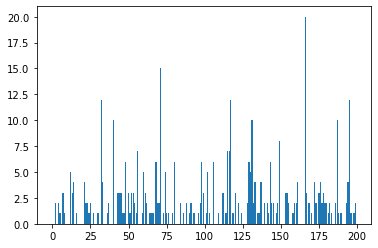

In [26]:
plt.bar(list(range(k)), frequency_vectors[0])
plt.show()

#### 3. Tf-idf

The above histogram does not consider the relevance of the visual words. That is why, we want to re-weight them using tf-idf. 

For reference, here is the formula. Try and refer to this if any of the following code is hard to understand.

$$tf\textrm{--}idf_{t,d} = tf_{t,d} * idf_t = tf_{t,d} * log\frac{N}{df_t}$$

where:

* $tf_{t,d}$ is the term frequency of the visual word $t$ in the image $d$ (the number of times $t$ occurs in $d$).
* $N$ is the total number of images.
* $df_t$ number of images containing visual word $t$.
* $log\frac{N}{df_t}$ measures the how common visual word $t$ is across all images in the database. This is low if the visual word $d$ occurs many times in the image, high otherwise.

Let's first calculate "*df*", given $N = 9469$, i.e., the length of our dataset.

In [27]:
# N is the number of images, i.e. the size of the dataset
N = 9469

# df is the number of images that a visual word appears in
# we calculate it by counting non-zero values as 1 and summing
df = np.sum(frequency_vectors > 0, axis=0)

In [28]:
df.shape, df[:5]

((200,), array([7935, 7373, 7869, 8106, 7320]))

*from this we know that visual word `0` appears in `7935` images, visual word `1` in `7373` images, and so on.*

Using `N` and `df` we can calculate *"idf"* (which is the same for every image).

In [29]:
idf = np.log(N/ df)
idf.shape, idf[:5]

((200,), array([0.17673995, 0.25019863, 0.18509232, 0.15541878, 0.25741298]))

Now we move on to the full tf-idf calculation, we just multiply the *"tf"* for each image by this `idf` vector. We have already calculated the *"tf"* values, they are the frequency vectors stored in `frequency_vectors`.

In [30]:
tfidf = frequency_vectors * idf
tfidf.shape, tfidf[0][:5]

((9469, 200),
 array([0.        , 0.        , 0.37018463, 0.        , 0.51482595]))

Visualizing the tf-idf vector for image `0` gives use:

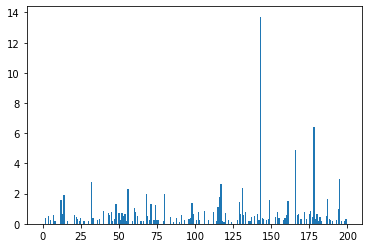

In [31]:
plt.bar(list(range(k)), tfidf[0])
plt.show()

### Finalizing Results

We have now generated tf-idf vectors based on the visual words of our images. To compare these images we can use a metric like *cosine similarity*.

We will use image `6` as our search term:

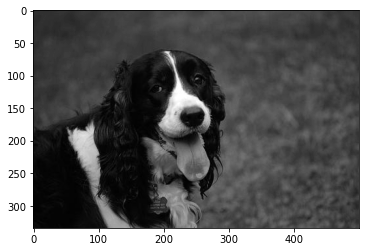

In [32]:
search_i = 6595

plt.imshow(bw_images[search_i], cmap='gray')
plt.show()

Again, for reference, our cosine similarity range is $[0,1]$, and it is calculated as follows:

$$cossim(A,B)= cos(\theta)=\frac{A \cdot B}{||A|| \space ||B||}$$

In [33]:
# cosine similarity
from numpy.linalg import norm

a = tfidf[search_i]
b = tfidf  # set search space to the full sample

cosine_similarity = np.dot(a, b.T)/(norm(a) * norm(b, axis=1))
print("Min cosine similarity:", round(np.min(cosine_similarity),1))
print("Max cosine similarity:", np.max(cosine_similarity))

Min cosine similarity: 0.0
Max cosine similarity: 1.0000000000000002


In our TF-IDF vectors, two highly similar images should be separated by a very small angular distance. Using cosine similarity, small angles output a high score (i.e., towards $1$).

Let's pick a random image from our dataset and retrieve the top 5 most similar images.

In [34]:
cosine_similarity.shape

(9469,)

In [35]:
cosine_similarity

array([0.20034286, 0.31255185, 0.15240567, ..., 0.47712785, 0.25135332,
       0.31855264])

To find the `top_k` most similar items, we use Numpy's `argpartition`.

In [36]:
top_k = 5
idx = np.argsort(-cosine_similarity)[:top_k]
idx

array([6595, 5902, 7667, 2185, 5804])

The first image in the array should correspond to the image itself. Therefore, the cosine similarity must be $≅1$.

In [37]:
cosine_similarity[idx[0]]

1.0000000000000002

6595: 1.0


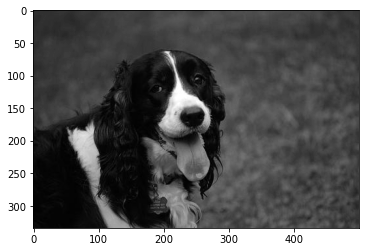

5902: 0.7195


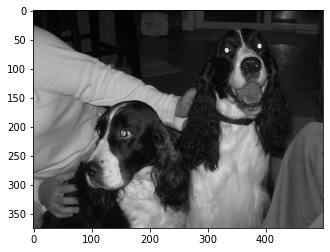

7667: 0.7081


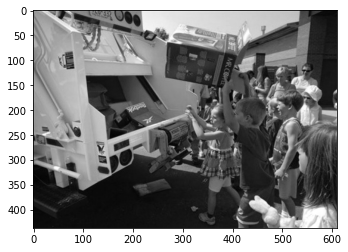

2185: 0.7068


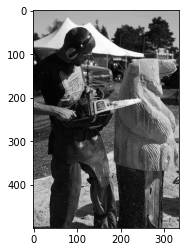

5804: 0.7007


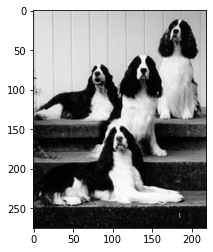

In [38]:
for i in idx:
    print(f"{i}: {round(cosine_similarity[i], 4)}")
    plt.imshow(bw_images[i], cmap='gray')
    plt.show()

This looks promising, we can test with a few more images.

In [39]:
def search(i: int, top_k: int = 5):
    print("Search image:")
    # show the search image
    plt.imshow(bw_images[i], cmap='gray')
    plt.show()
    print("-----------------------------------------------------")
    # get search image vector
    a = tfidf[i]
    # get the cosine distance for the search image `a`
    cosine_similarity = np.dot(a, b.T)/(norm(a) * norm(b, axis=1))
    # get the top k indices for most similar vecs
    idx = np.argsort(-cosine_similarity)[:top_k]
    # display the results
    for i in idx:
        print(f"{i}: {round(cosine_similarity[i], 4)}")
        plt.imshow(bw_images[i], cmap='gray')
        plt.show()

Search image:


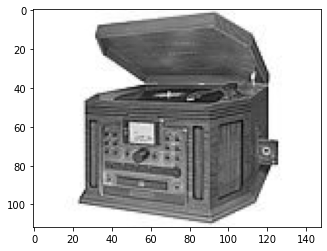

-----------------------------------------------------
10: 1.0


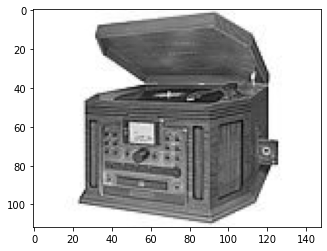

913: 0.7889


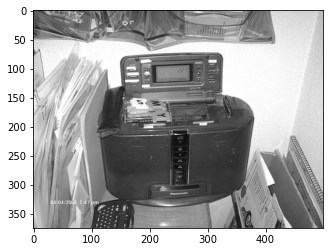

8773: 0.7776


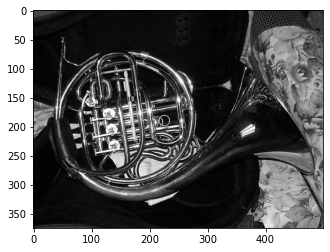

6160: 0.7752


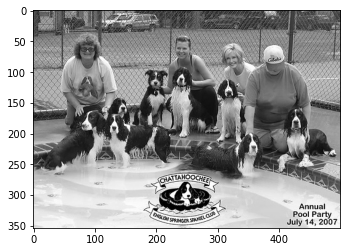

649: 0.7749


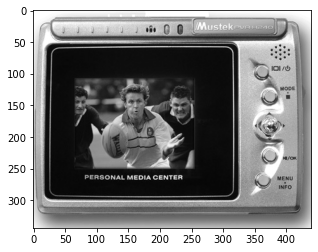

In [40]:
search(10)

Search image:


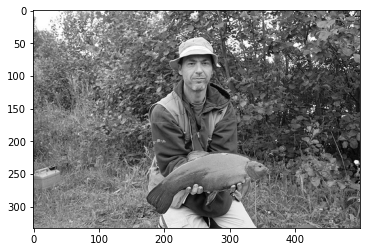

-----------------------------------------------------
1200: 1.0


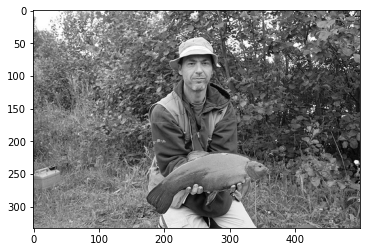

1609: 0.944


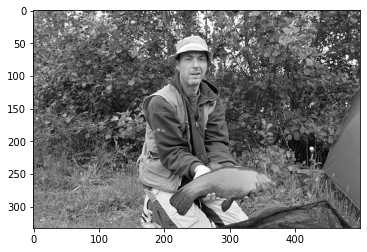

1739: 0.9397


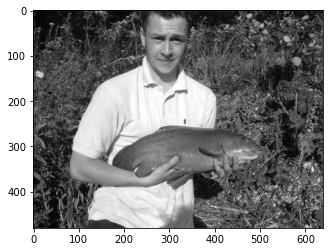

4722: 0.9346


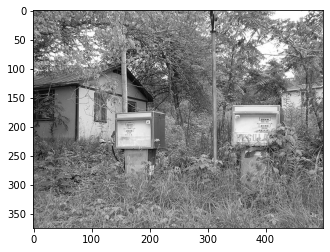

7381: 0.9304


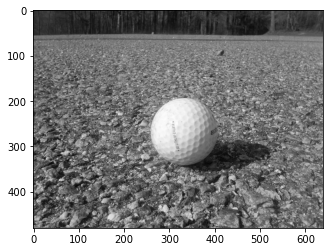

In [41]:
search(1200)

Search image:


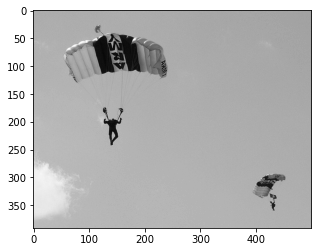

-----------------------------------------------------
4000: 1.0


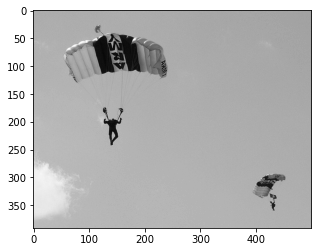

7435: 0.8127


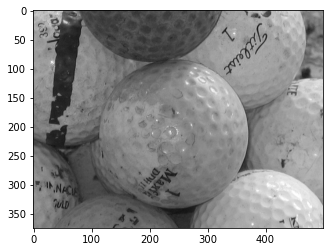

7186: 0.8015


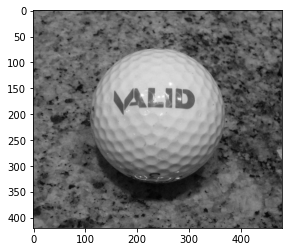

6054: 0.7863


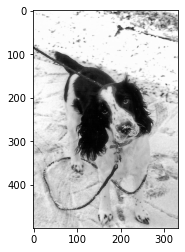

7282: 0.7862


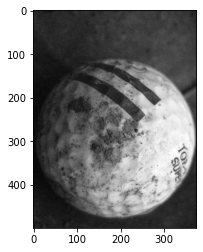

In [42]:
search(4000)

Search image:


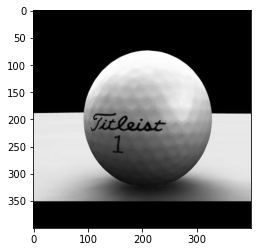

-----------------------------------------------------
6921: 1.0


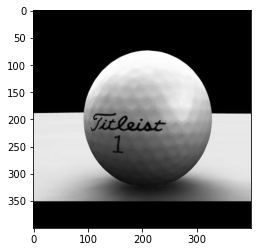

7051: 0.6527


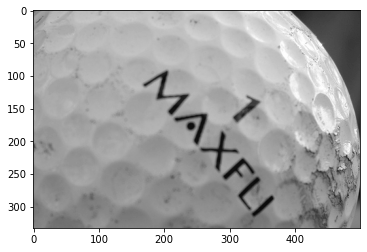

7119: 0.6196


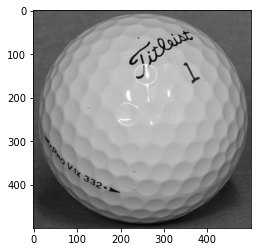

6896: 0.6186


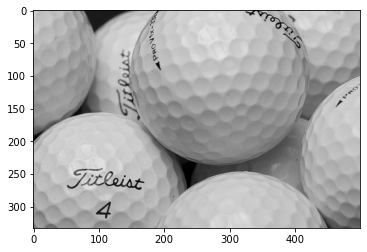

8065: 0.616


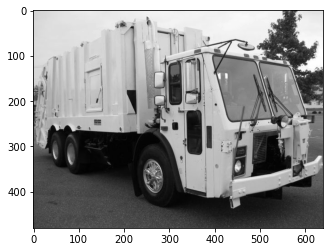

In [43]:
search(6921)

Search image:


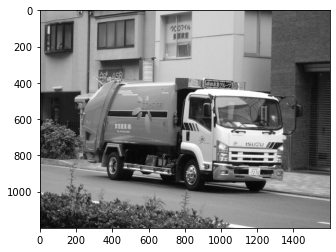

-----------------------------------------------------
8052: 1.0


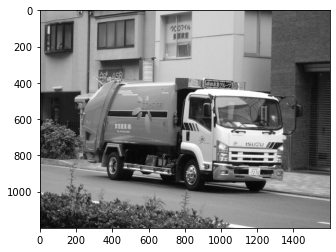

7840: 0.9281


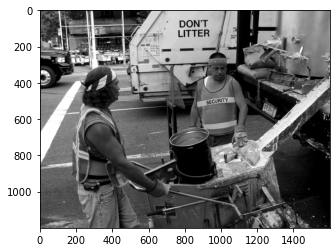

8093: 0.9207


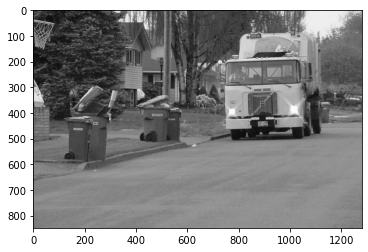

1501: 0.9153


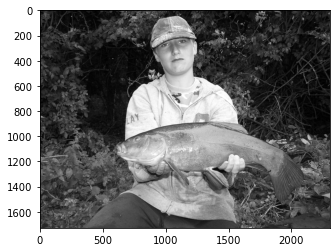

9054: 0.9151


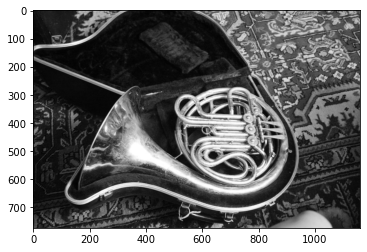

In [44]:
search(8052)

The results are not always perfect, but for the most part it seems to manage in returning similar images.

---